# Introduction to FermiLib
Note that all the examples below must be run sequentially within a section.

## Initializing the FermionOperator data structure

Fermionic systems are often treated in second quantization where arbitrary operators can be expressed using the fermionic creation and annihilation operators, $a^\dagger_k$ and $a_k$.  The fermionic ladder operators play a similar role to their qubit ladder operator counterparts, $\sigma^+_k$ and $\sigma^-_k$ but are distinguished by the cannonical fermionic anticommutation relations, $\{a^\dagger_i, a^\dagger_j\} = \{a_i, a_j\} = 0$ and $\{a_i, a_j^\dagger\} = \delta_{ij}$. Any weighted sums of products of these operators are represented with the FermionOperator data structure in FermiLib. The following are examples of valid FermionOperators:

$$
\begin{align}
& a_1 \nonumber \\
& 1.7 a^\dagger_3 \nonumber \\
&-1.7 \, a^\dagger_3 a_1 \nonumber \\
&(1 + 2i) \, a^\dagger_4 a^\dagger_3 a_9 a_1 \nonumber \\
&(1 + 2i) \, a^\dagger_4 a^\dagger_3 a_9 a_1 - 1.7 \, a^\dagger_3 a_1 \nonumber
\end{align}
$$

The FermionOperator class is contained in $\textrm{ops/_fermion_operators.py}$. In order to support fast addition of FermionOperator instances, the class is implemented as hash table (python dictionary). The keys of the dictionary encode the strings of ladder operators and values of the dictionary store the coefficients. The strings of ladder operators are encoded as a tuple of 2-tuples which we refer to as the "terms tuple". Each ladder operator is represented by a 2-tuple. The first element of the 2-tuple is an int indictating the tensor factor on which the ladder operator acts. The second element of the 2-tuple is Boole: 1 represents raising and 0 represents lowering. For instance, $a^\dagger_8$ is represented in a 2-tuple as $(8, 1)$. Note that indices start at 0 and the identity operator is an empty list. Below we give some examples of operators and their terms tuple:

$$
\begin{align}
I & \mapsto () \nonumber \\
a_1 & \mapsto ((1, 0),) \nonumber \\
a^\dagger_3 & \mapsto ((3, 1),) \nonumber \\
a^\dagger_3 a_1 & \mapsto ((3, 1), (1, 0)) \nonumber \\
a^\dagger_4 a^\dagger_3 a_9 a_1 & \mapsto ((4, 1), (3, 1), (9, 0), (1, 0)) \nonumber
\end{align}
$$

Note that when initializing a single ladder operator one should be careful to add the comma after the inner pair. This is because in python ((1, 2)) = (1, 2) whereas ((1, 2),) = ((1, 2),). The "terms tuple" is usually convenient when one wishes to initialize a term as part of a coded routine. However, the terms tuple is not particularly intuitive. Accordingly, FermiLib also supports another user-friendly, string notation below. This representation is rendered when calling "print" on a FermionOperator.

$$
\begin{align}
I & \mapsto \textrm{""} \nonumber \\
a_1 & \mapsto \textrm{"1"} \nonumber \\
a^\dagger_3 & \mapsto \textrm{"3^"} \nonumber \\
a^\dagger_3 a_1 & \mapsto \textrm{"3^}\;\textrm{1"} \nonumber \\
a^\dagger_4 a^\dagger_3 a_9 a_1 & \mapsto \textrm{"4^}\;\textrm{3^}\;\textrm{9}\;\textrm{1"} \nonumber
\end{align}
$$

Let's initialize our first term! We do it two different ways below.

In [14]:
from fermilib.ops import FermionOperator

my_term = FermionOperator(((3, 1), (1, 0)))
print(my_term)

my_term = FermionOperator('3^ 1')
print(my_term)

1.0 [3^ 1]
1.0 [3^ 1]


The preferred way to specify the coefficient in FermiLib is to provide an optional coefficient argument. If not provided, the coefficient defaults to 1. In the code below, the first method is preferred. The multiplication in the second method actually creates a copy of the term, which introduces some additional cost. All inplace operands (such as +=) modify classes whereas binary operands such as + create copies. Important caveats are that the empty tuple FermionOperator(()) and the empty string FermionOperator('') initializes identity. The empty initializer FermionOperator() initializes the zero operator.

In [15]:
good_way_to_initialize = FermionOperator('3^ 1', -1.7)
print(good_way_to_initialize)

bad_way_to_initialize = -1.7 * FermionOperator('3^ 1')
print(bad_way_to_initialize)

identity = FermionOperator('')
print(identity)

zero_operator = FermionOperator()
print(zero_operator)

-1.7 [3^ 1]
-1.7 [3^ 1]
1.0 []
0


Note that FermionOperator has only one attribute: .terms. This attribute is the dictionary which stores the term tuples.

In [16]:
my_operator = FermionOperator('4^ 1^ 3 9', 1. + 2.j)
print(my_operator)
print(my_operator.terms)

(1+2j) [4^ 1^ 3 9]
{((4, 1), (1, 1), (3, 0), (9, 0)): (1+2j)}


## Manipulating the FermionOperator data structure
So far we have explained how to initialize a single FermionOperator such as $-1.7 \, a^\dagger_3 a_1$. However, in general we will want to represent sums of these operators such as $(1 + 2i) \, a^\dagger_4 a^\dagger_3 a_9 a_1 - 1.7 \, a^\dagger_3 a_1$. To do this, just add together two FermionOperators! We demonstrate below.

In [17]:
from fermilib.ops import FermionOperator

term_1 = FermionOperator('4^ 3^ 9 1', 1. + 2.j)
term_2 = FermionOperator('3^ 1', -1.7)
my_operator = term_1 + term_2
print(my_operator)

my_operator = FermionOperator('4^ 3^ 9 1', 1. + 2.j)
term_2 = FermionOperator('3^ 1', -1.7)
my_operator += term_2
print('')
print(my_operator)

(1+2j) [4^ 3^ 9 1] +
-1.7 [3^ 1]

(1+2j) [4^ 3^ 9 1] +
-1.7 [3^ 1]


The print function prints each term in the operator on a different line. Note that the line my_operator = term_1 + term_2 creates a new object, which involves a copy of term_1 and term_2. The second block of code uses the inplace method +=, which is more efficient. This is especially important when trying to construct a very large FermionOperator. FermionOperators also support a wide range of builtins including, str(), repr(), *=, *, /, /=, +, +=, -, -=, - and **. Note that instead of supporting != and ==, we have the method .isclose(), since FermionOperators involve floats. We demonstrate some of these methods below.

In [18]:
term_1 = FermionOperator('4^ 3^ 9 1', 1. + 2.j)
term_2 = FermionOperator('3^ 1', -1.7)

my_operator = term_1 - 33. * term_2
print(my_operator)

my_operator *= 3.17 * (term_2 + term_1) ** 2
print('')
print(my_operator)

print('')
print(term_2 ** 3)

print('')
print(term_1.isclose(2.*term_1 - term_1))
print(term_1.isclose(my_operator))

(1+2j) [4^ 3^ 9 1] +
56.1 [3^ 1]

(-302.3229-604.6458j) [3^ 1 3^ 1 4^ 3^ 9 1] +
(9.1613+18.3226j) [4^ 3^ 9 1 3^ 1 3^ 1] +
(16.167-21.556j) [4^ 3^ 9 1 3^ 1 4^ 3^ 9 1] +
(-302.3229-604.6458j) [3^ 1 4^ 3^ 9 1 3^ 1] +
(-34.87-6.34j) [4^ 3^ 9 1 4^ 3^ 9 1 4^ 3^ 9 1] +
(16.167-21.556j) [4^ 3^ 9 1 4^ 3^ 9 1 3^ 1] +
513.94893 [3^ 1 3^ 1 3^ 1] +
(-533.511+711.348j) [3^ 1 4^ 3^ 9 1 4^ 3^ 9 1]

-4.913 [3^ 1 3^ 1 3^ 1]

True
False


Additionally, there are a variety of methods that act on the FermionOperator data structure. We demonstrate a small subset of those methods here.

In [19]:
from fermilib.ops import hermitian_conjugated, normal_ordered
from fermilib.utils import commutator, count_qubits

# Get the Hermitian conjugate of a FermionOperator, count its qubit, check if it is normal-ordered.
term_1 = FermionOperator('4^ 3 3^', 1. + 2.j)
print(hermitian_conjugated(term_1))
print(term_1.is_normal_ordered())
print(count_qubits(term_1))

# Normal order the term.
term_2 = normal_ordered(term_1)
print('')
print(term_2)
print(term_2.is_normal_ordered())

# Compute a commutator of the terms.
print('')
print(commutator(term_1, term_2))

(1-2j) [3 3^ 4]
False
5

(-1-2j) [4^ 3^ 3] +
(1+2j) [4^]
True

(3-4j) [4^ 4^ 3 3^] +
(-3+4j) [4^ 3 3^ 4^] +
(3-4j) [4^ 3 3^ 4^ 3^ 3] +
(-3+4j) [4^ 3^ 3 4^ 3 3^]


## The QubitOperator data structure
The QubitOperator data structure is another essential part of FermiLib. While the QubitOperator was originally developed for FermiLib, it is now part of the core ProjectQ library so that it can be interpreted by the ProjectQ compiler using the TimeEvolution gate. As the name suggests, QubitOperator is used to store qubit operators in almost exactly the same way that FermionOperator is used to store fermion operators. For instance $X_0 Z_3 Y_4$ is a QubitOperator. The internal representation of this as a terms tuple would be $((0, \textrm{"X"}), (3, \textrm{"Z"}), (4, \textrm{"Y"}))$. Note that one important difference between QubitOperator and FermionOperator is that the terms in QubitOperator are always sorted in order of tensor factor. In some cases, this enables faster manipulation. We initialize some QubitOperators below.

In [20]:
from projectq.ops import QubitOperator

my_first_qubit_operator = QubitOperator('X1 Y2 Z3')
print(my_first_qubit_operator)
print(my_first_qubit_operator.terms)

operator_2 = QubitOperator('X3 Z4', 3.17)
operator_2 -= 77. * my_first_qubit_operator
print('')
print(operator_2)

1.0 X1 Y2 Z3
{((1, 'X'), (2, 'Y'), (3, 'Z')): 1.0}

-77.0 X1 Y2 Z3 +
3.17 X3 Z4


## Jordan-Wigner and Bravyi-Kitaev
FermiLib provides functions for mapping FermionOperators to QubitOperators.

In [21]:
from fermilib.ops import FermionOperator, hermitian_conjugated
from fermilib.transforms import jordan_wigner, bravyi_kitaev
from fermilib.utils import eigenspectrum

# Initialize an operator.
fermion_operator = FermionOperator('2^ 0', 3.17)
fermion_operator += hermitian_conjugated(fermion_operator)
print(fermion_operator)

# Transform to qubits under the Jordan-Wigner transformation and print its spectrum.
jw_operator = jordan_wigner(fermion_operator)
print('')
print(jw_operator)
jw_spectrum = eigenspectrum(jw_operator)
print(jw_spectrum)

# Transform to qubits under the Bravyi-Kitaev transformation and print its spectrum.
bk_operator = bravyi_kitaev(fermion_operator)
print('')
print(bk_operator)
bk_spectrum = eigenspectrum(bk_operator)
print(bk_spectrum)

3.17 [2^ 0] +
3.17 [0^ 2]

(1.585+0j) Y0 Z1 Y2 +
(1.585+0j) X0 Z1 X2
[-3.17 -3.17  0.    0.    0.    0.    3.17  3.17]

(-1.585+0j) Y0 Y1 +
(-1.585+0j) X0 X1 Z2
[-3.17 -3.17  0.    0.    0.    0.    3.17  3.17]


We see that despite the different representation, these operators are iso-spectral. We can also apply the Jordan-Wigner transform in reverse to map arbitrary QubitOperators to FermionOperators. Note that we also demonstrate the .compress() method (a method on both FermionOperators and QubitOperators) which removes zero entries.

In [22]:
from fermilib.transforms import reverse_jordan_wigner

# Initialize QubitOperator.
my_operator = QubitOperator('X0 Y1 Z2', 88.)
my_operator += QubitOperator('Z1 Z4', 3.17)
print(my_operator)

# Map QubitOperator to a FermionOperator.
mapped_operator = reverse_jordan_wigner(my_operator)
print('')
print(mapped_operator)

# Map the operator back to qubits and make sure it is the same.
back_to_normal = jordan_wigner(mapped_operator)
back_to_normal.compress()
print('')
print(back_to_normal)

88.0 X0 Y1 Z2 +
3.17 Z1 Z4

-6.34 [4^ 4] +
176j [2^ 2 1 0] +
88j [1 0^] +
-88j [1 0] +
-88j [1^ 0^] +
12.68 [4^ 4 1^ 1] +
3.17 [] +
-176j [2^ 2 1 0^] +
88j [1^ 0] +
-6.34 [1^ 1] +
-176j [2^ 2 1^ 0] +
176j [2^ 2 1^ 0^]

88.0 X0 Y1 Z2 +
3.17 Z1 Z4


## Sparse matrices and the Hubbard model
Often, one would like to obtain a sparse matrix representation of an operator which can be analyzed numerically. There is code in both fermilib.transforms and fermilib.utils which facilitates this. The function get_sparse_operator converts either a FermionOperator, a QubitOperator or other more advanced classes such as InteractionOperator to a scipy.sparse.csc matrix. There are numerous functions in fermilib.utils which one can call on the sparse operators such as "get_gap", "get_hartree_fock_state", "get_ground_state", ect. We show this off by computing the ground state energy of the Hubbard model. To do that, we use code from the fermilib.utils module which constructs lattice models of fermions such as Hubbard models.

In [23]:
from fermilib.transforms import get_sparse_operator, jordan_wigner
from fermilib.utils import fermi_hubbard, get_ground_state

# Set model.
x_dimension = 2
y_dimension = 2
tunneling = 2.
coulomb = 1.
magnetic_field = 0.5
chemical_potential = 0.25
periodic = 1
spinless = 1

# Get fermion operator.
hubbard_model = fermi_hubbard(
    x_dimension, y_dimension, tunneling, coulomb, chemical_potential,
    magnetic_field, periodic, spinless)
print(hubbard_model)

# Get qubit operator under Jordan-Wigner.
jw_hamiltonian = jordan_wigner(hubbard_model)
jw_hamiltonian.compress()
print('')
print(jw_hamiltonian)

# Get scipy.sparse.csc representation.
sparse_operator = get_sparse_operator(hubbard_model)
print('')
print(sparse_operator)
print('\nEnergy of the model is {} in units of T and J.'.format(
    get_ground_state(sparse_operator)[0]))

0.25 [2^ 2] +
1.0 [2^ 2 3^ 3] +
-2.0 [0^ 1] +
-2.0 [1^ 3] +
-2.0 [3^ 2] +
0.25 [3^ 3] +
1.0 [0^ 0 1^ 1] +
-2.0 [2^ 3] +
-2.0 [0^ 2] +
-2.0 [3^ 1] +
0.0 [] +
-2.0 [1^ 0] +
-2.0 [2^ 0] +
-0.25 [0^ 0] +
1.0 [0^ 0 2^ 2] +
-0.25 [1^ 1] +
1.0 [1^ 1 3^ 3]

-1.0 X2 X3 +
-1.0 X1 Z2 X3 +
0.25 Z0 Z2 +
-0.625 Z2 +
0.25 Z2 Z3 +
-0.375 Z0 +
-0.625 Z3 +
0.25 Z0 Z1 +
0.25 Z1 Z3 +
-1.0 Y2 Y3 +
1.0 I +
-0.375 Z1 +
-1.0 X0 Z1 X2 +
-1.0 Y1 Z2 Y3 +
-1.0 Y0 Z1 Y2 +
-1.0 X0 X1 +
-1.0 Y0 Y1

  (1, 1)	(0.25+0j)
  (2, 1)	(-2+0j)
  (4, 1)	(-2+0j)
  (1, 2)	(-2+0j)
  (2, 2)	(0.25+0j)
  (8, 2)	(-2+0j)
  (3, 3)	(1.5+0j)
  (6, 3)	(2+0j)
  (9, 3)	(-2+0j)
  (1, 4)	(-2+0j)
  (4, 4)	(-0.25+0j)
  (8, 4)	(-2+0j)
  (5, 5)	(1+0j)
  (6, 5)	(-2+0j)
  (9, 5)	(-2+0j)
  (3, 6)	(2+0j)
  (5, 6)	(-2+0j)
  (10, 6)	(-2+0j)
  (12, 6)	(2+0j)
  (7, 7)	(2.25+0j)
  (11, 7)	(-2+0j)
  (13, 7)	(2+0j)
  (2, 8)	(-2+0j)
  (4, 8)	(-2+0j)
  (8, 8)	(-0.25+0j)
  (3, 9)	(-2+0j)
  (5, 9)	(-2+0j)
  (10, 9)	(-2+0j)
  (12, 9)	(-2+0j)
  (6, 10)	(-2+0j)
  

## Hamiltonians in the plane wave basis
A user can write plugins to FermiLib which allow for the use of, e.g., third-party electronic structure package to compute molecular orbitals, Hamiltonians, energies, reduced density matrices, coupled cluster amplitudes, etc using Gaussian basis sets. We may provide scripts which interface between such packages and FermiLib in future but do not discuss them in this tutorial.

When using simpler basis sets such as plane waves, these packages are not needed. FermiLib comes with code which computes Hamiltonians in the plane wave basis. Note that when using plane waves, one is working with the periodized Coulomb operator, best suited for condensed phase calculations such as studying the electronic structure of a solid. To obtain these Hamiltonians one must choose to study the system without a spin degree of freedom (spinless), one must the specify dimension in which the calculation is performed (n_dimensions, usually 3), one must specify how many plane waves are in each dimension (grid_length) and one must specify the length scale of the plane wave harmonics in each dimension (length_scale) and also the locations and charges of the nuclei. One can generate these models with plane_wave_hamiltonian() found in fermilib.utils. For simplicity, below we compute the Hamiltonian in the case of zero external charge (corresponding to the uniform electron gas, aka jellium). We also demonstrate that one can transform the plane wave Hamiltonian using a Fourier transform without effecting the spectrum of the operator.

In [24]:
from fermilib.utils import eigenspectrum, fourier_transform, jellium_model, Grid
from fermilib.transforms import jordan_wigner

# Let's look at a very small model of jellium in 1D.
grid = Grid(dimensions=1, length=3, scale=1.0)
spinless = True

# Get the momentum Hamiltonian.
momentum_hamiltonian = jellium_model(grid, spinless)
momentum_qubit_operator = jordan_wigner(momentum_hamiltonian)
momentum_qubit_operator.compress()
print(momentum_qubit_operator)

# Fourier transform the Hamiltonian to the position basis.
position_hamiltonian = fourier_transform(momentum_hamiltonian, grid, spinless)
position_qubit_operator = jordan_wigner(position_hamiltonian)
position_qubit_operator.compress()
print('')
print (position_qubit_operator)

# Check the spectra to make sure these representations are iso-spectral.
spectral_difference = eigenspectrum(momentum_qubit_operator) -  eigenspectrum(position_qubit_operator)
print('')
print(spectral_difference)

-0.0795774715459 Z0 Z2 +
-0.0795774715459 Z0 Z1 +
-9.710449458 Z2 +
-9.710449458 Z0 +
-0.0795774715459 Z1 Z2 +
19.5004763875 I +
0.159154943092 Z1

-0.0795774715459 Z0 Z2 +
-3.2898681337 Y1 Y2 +
-6.4205813243 Z2 +
-0.0795774715459 Z1 Z2 +
-6.4205813243 Z0 +
-3.2898681337 Y0 Y1 +
-0.0795774715459 Z0 Z1 +
19.5004763875 I +
-6.4205813243 Z1 +
-3.2898681337 X0 Z1 X2 +
-3.2898681337 X1 X2 +
-3.2898681337 Y0 Z1 Y2 +
-3.2898681337 X0 X1

[  3.45556916e-15   3.59434704e-15   3.55271368e-15  -7.10542736e-15
   7.10542736e-15  -7.10542736e-15  -7.10542736e-15  -7.10542736e-15]


## Basics of MolecularData class

Data from electronic structure calculations can be saved in a FermiLib data structure called MolecularData, which makes it easy to access within our library. Often, one would like to analyze a chemical series or look at many different Hamiltonians and sometimes the electronic structure calculations are either expensive to compute or difficult to converge (e.g. one needs to mess around with different types of SCF routines to make things converge). Accordingly, we anticipate that users will want some way to automatically database the results of their electronic structure calculations so that important data (such as the SCF intergrals) can be looked up on-the-fly if the user has computed them in the past. FermiLib supports a data provenance strategy which saves key results of the electronic structure calculation (including pointers to files containing large amounts of data, such as the molecular integrals) in an HDF5 container.

The MolecularData class stores information about molecules. One initializes a MolecularData object by specifying parameters of a molecule such as its geometry, basis, multiplicity, charge and an optional string describing it. One can also initialize MolecularData simply by providing a string giving a filename where a previous MolecularData object was saved in an HDF5 container. One can save a MolecularData instance by calling the class's .save() method. This automatically saves the instance in a data folder specified during FermiLib installation. The name of the file is generated automatically from the instance attributes and optionally provided description. Alternatively, a filename can also be provided as an optional input if one wishes to manually name the file.

When electronic structure calculations are run, the data files for the molecule can be automatically updated. If one wishes to later use that data they either initialize MolecularData with the instance filename or initialize the instance and then later call the .load() method.

Basis functions are provided to initialization using a string such as "6-31g". Geometries can be specified using a simple txt input file (see geometry_from_file function in molecular_data.py) or can be passed using a simple python list format demonstrated below. Atoms are specified using a string for their atomic symbol. Distances should be provided in atomic units (Bohr). Below we initialize a simple instance of MolecularData without performing any electronic structure calculations.

In [25]:
from fermilib.utils import MolecularData

# Set parameters to make a simple molecule.
diatomic_bond_length = .7414
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1
charge = 0
description = str(diatomic_bond_length)

# Make molecule and print out a few interesting facts about it.
molecule = MolecularData(geometry, basis, multiplicity,
                         charge, description)
print('Molecule has automatically generated name {}'.format(
    molecule.name))
print('Information about this molecule would be saved at:\n{}\n'.format(
    molecule.filename))
print('This molecule has {} atoms and {} electrons.'.format(
    molecule.n_atoms, molecule.n_electrons))
for atom, atomic_number in zip(molecule.atoms, molecule.protons):
    print('Contains {} atom, which has {} protons.'.format(
        atom, atomic_number))

Molecule has automatically generated name H2_sto-3g_singlet_0.7414
Information about this molecule would be saved at:
/Users/Lappy/Dropbox/Programming/fermilib/src/fermilib/data/H2_sto-3g_singlet_0.7414

This molecule has 2 atoms and 2 electrons.
Contains H atom, which has 1 protons.
Contains H atom, which has 1 protons.


If we had previously computed this molecule using an electronic structure package, we can call molecule.load() to populate all sorts of interesting fields in the data structure. Though we make no assumptions about what electronic structure packages users might install, we assume that the calculations are saved in Fermilib's MolecularData objects. There may be plugins available in future. For the purposes of this example, we will load data that ships with FermiLib to make a plot of the energy surface of hydrogen. Note that helper functions to initialize some interesting chemical benchmarks are found in fermilib.utils.

0.3

At bond length of 0.3 Bohr, molecular hydrogen has:
Hartree-Fock energy of -0.593827764585 Hartree.
MP2 energy of -0.599781278607 Hartree.
FCI energy of -0.601803716835 Hartree.
Nuclear repulsion energy between protons is 1.76392402863 Hartree.
Spatial orbital 0 has energy of -0.802866618712 Hartree.
Spatial orbital 1 has energy of 1.36893879525 Hartree.
0.4

At bond length of 0.4 Bohr, molecular hydrogen has:
Hartree-Fock energy of -0.904361397714 Hartree.
MP2 energy of -0.911435297618 Hartree.
FCI energy of -0.914149708214 Hartree.
Nuclear repulsion energy between protons is 1.32294302147 Hartree.
Spatial orbital 0 has energy of -0.745212533291 Hartree.
Spatial orbital 1 has energy of 1.16741639504 Hartree.
0.5

At bond length of 0.5 Bohr, molecular hydrogen has:
Hartree-Fock energy of -1.04299627651 Hartree.
MP2 energy of -1.05148447259 Hartree.
FCI energy of -1.0551597965 Hartree.
Nuclear repulsion energy between protons is 1.05835441718 Hartree.
Spatial orbital 0 has energy o

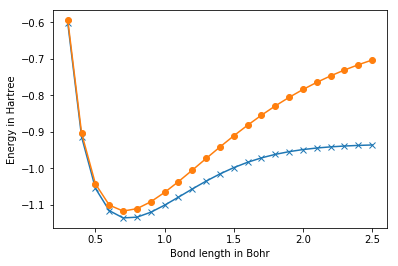

In [27]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
bond_length_interval = 0.1
n_points = 25

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for point in range(3, n_points + 1):
    bond_length = bond_length_interval * point
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
    print(description)
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()

    # Print out some results of calculation.
    print('\nAt bond length of {} Bohr, molecular hydrogen has:'.format(
        bond_length))
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
    print('MP2 energy of {} Hartree.'.format(molecule.mp2_energy))
    print('FCI energy of {} Hartree.'.format(molecule.fci_energy))
    print('Nuclear repulsion energy between protons is {} Hartree.'.format(
        molecule.nuclear_repulsion))
    for orbital in range(molecule.n_orbitals):
        print('Spatial orbital {} has energy of {} Hartree.'.format(
            orbital, molecule.orbital_energies[orbital]))
    hf_energies += [molecule.hf_energy]
    fci_energies += [molecule.fci_energy]

# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'x-')
plt.plot(bond_lengths, hf_energies, 'o-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in Bohr')
plt.show()

## InteractionOperator and InteractionRDM for efficient numerical representations

Fermion Hamiltonians can be expressed as $H = h_0 + \sum_{pq} h_{pq}\, a^\dagger_p a_q + \frac{1}{2} \sum_{pqrs} h_{pqrs} \, a^\dagger_p a^\dagger_q a_r a_s$ where $h_0$ is a constant shift due to the nuclear repulsion and $h_{pq}$ and $h_{pqrs}$ are the famous molecular integrals. Since fermions interact pairwise, their energy is thus a unique function of the one-particle and two-particle reduced density matrices which are expressed in second quantization as $\rho_{pq} = \left \langle p \mid a^\dagger_p a_q \mid q \right \rangle$ and $\rho_{pqrs} = \left \langle pq \mid a^\dagger_p a^\dagger_q a_r a_s \mid rs \right \rangle$, respectively.

Because the RDMs and molecular Hamiltonians are both compactly represented and manipulated as 2- and 4- index tensors, we can represent them in a particularly efficient form using  similar data structures. The InteractionOperator data structure can be initialized for a Hamiltonian by passing the constant $h_0$ (or 0), as well as numpy arrays representing $h_{pq}$ (or $\rho_{pq}$) and $h_{pqrs}$ (or $\rho_{pqrs}$). Importantly, InteractionOperators can also be obtained by calling MolecularData.get_molecular_hamiltonian() or by calling the function get_interaction_operator() (found in fermilib.utils) on a FermionOperator. The InteractionRDM data structure is similar but represents RDMs. For instance, one can get a molecular RDM by calling MolecularData.get_molecular_rdm(). When generating Hamiltonians from the MolecularData class, one can choose to restrict the system to an active space.

These classes inherit from the same base class, InteractionTensor. This data structure overloads the slice operator [] so that one can get or set the key attributes of the InteractionOperator: $\textrm{.constant}$, $\textrm{.one_body_coefficients}$ and $\textrm{.two_body_coefficients}$ . For instance, InteractionOperator[p,q,r,s] would return $h_{pqrs}$ and InteractionRDM would return $\rho_{pqrs}$. Importantly, the class supports fast basis transformations using the method InteractionTensor.rotate_basis(rotation_matrix).
But perhaps most importantly, one can map the InteractionOperator to any of the other data structures we've described here.

Below, we load MolecularData from a saved calculation of LiH. We then obtain an InteractionOperator representation of this system in an active space. We then map that operator to qubits. We then demonstrate that one can rotate the orbital basis of the InteractionOperator using random angles to obtain a totally different operator that is still iso-spectral.

In [28]:
from fermilib.transforms import get_fermion_operator, get_sparse_operator, jordan_wigner
from fermilib.utils import get_ground_state, MolecularData
import numpy
import scipy
import scipy.linalg

# Load saved file for LiH.
diatomic_bond_length = 1.45
geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1

# Set Hamiltonian parameters.
active_space_start = 1
active_space_stop = 3

# Generate and populate instance of MolecularData.
molecule = MolecularData(geometry, basis, multiplicity, description="1.45")
molecule.load()

# Get the Hamiltonian in an active space.
molecular_hamiltonian = molecule.get_molecular_hamiltonian(
    occupied_indices=range(active_space_start),
    active_indices=range(active_space_start, active_space_stop))

# Map operator to fermions and qubits.
fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
qubit_hamiltonian.compress()
print('The Jordan-Wigner Hamiltonian in canonical basis follows:\n{}'.format(qubit_hamiltonian))

# Get sparse operator and ground state energy.
sparse_hamiltonian = get_sparse_operator(qubit_hamiltonian)
energy, state = get_ground_state(sparse_hamiltonian)
print('Ground state energy before rotation is {} Hartree.\n'.format(energy))

# Randomly rotate.
n_orbitals = molecular_hamiltonian.n_qubits // 2
n_variables = int(n_orbitals * (n_orbitals - 1) / 2)
random_angles = numpy.pi * (1. - 2. * numpy.random.rand(n_variables))
kappa = numpy.zeros((n_orbitals, n_orbitals))
index = 0
for p in range(n_orbitals):
    for q in range(p + 1, n_orbitals):
        kappa[p, q] = random_angles[index]
        kappa[q, p] = -numpy.conjugate(random_angles[index])
        index += 1

    # Build the unitary rotation matrix.
    difference_matrix = kappa + kappa.transpose()
    rotation_matrix = scipy.linalg.expm(kappa)

    # Apply the unitary.
    molecular_hamiltonian.rotate_basis(rotation_matrix)

# Get qubit Hamiltonian in rotated basis.
qubit_hamiltonian = jordan_wigner(molecular_hamiltonian)
qubit_hamiltonian.compress()
print('The Jordan-Wigner Hamiltonian in rotated basis follows:\n{}'.format(qubit_hamiltonian))

# Get sparse Hamiltonian and energy in rotated basis.
sparse_hamiltonian = get_sparse_operator(qubit_hamiltonian)
energy, state = get_ground_state(sparse_hamiltonian)
print('Ground state energy after rotation is {} Hartree.'.format(energy))

The Jordan-Wigner Hamiltonian in canonical basis follows:
0.0129107802731 X1 Z2 X3 +
0.0115364132008 Z0 X1 Z2 X3 +
-0.0132436983303 Z2 +
-0.0013743761079 Y0 Z1 Y2 Z3 +
0.0115364132008 Z0 Y1 Z2 Y3 +
0.124447701331 Z0 Z1 +
-0.0013743761079 Y1 Y3 +
-0.0013743761079 X0 Z1 X2 Z3 +
-0.00293299644095 X0 X1 Y2 Y3 +
0.16199475388 Z0 +
0.0541304457933 Z1 Z3 +
0.16199475388 Z1 +
0.0129107802731 X0 Z1 X2 +
0.0115364132008 X0 X2 +
0.0129107802731 Y0 Z1 Y2 +
0.0541304457933 Z0 Z2 +
0.0847960954367 Z2 Z3 +
0.00293299644095 Y0 X1 X2 Y3 +
-0.0132436983303 Z3 +
0.0570634422342 Z1 Z2 +
0.0129107802731 Y1 Z2 Y3 +
0.0115364132008 Y0 Y2 +
0.0570634422342 Z0 Z3 +
-0.00293299644095 Y0 Y1 X2 X3 +
-7.49894690201 I +
0.00293299644095 X0 Y1 Y2 X3 +
-0.0013743761079 X1 X3
Ground state energy before rotation is -7.86277316303 Hartree.

The Jordan-Wigner Hamiltonian in rotated basis follows:
-0.0458216167118 X1 Z2 X3 +
0.00343903835619 Z0 X1 Z2 X3 +
0.150166005227 Z2 +
0.00343903835619 X0 X2 +
0.00343903835619 Z0 Y1

## Simulating a variational quantum eigensolver using ProjectQ
We now demonstrate how one can use both FermiLib and ProjectQ to run a simple VQE example using a Unitary Coupled Cluster ansatz. It demonstrates a simple way to evaluate the energy, optimize the energy with respect to the ansatz and build the corresponding compiled quantum circuit. It utilizes ProjectQ to build and simulate the circuit.

In [7]:
from numpy import array, concatenate, zeros
from numpy.random import randn
from scipy.optimize import minimize

from fermilib.config import *
from fermilib.utils import *
from fermilib.transforms import jordan_wigner

from projectq.ops import X, All, Measure
from projectq.backends import CommandPrinter, CircuitDrawer

Here we load $\textrm{H}_2$ from a precomputed molecule file found in the test data directory, and initialize the ProjectQ circuit compiler to a standard setting that uses a first-order Trotter decomposition to break up the exponentials of non-commuting operators. 

In [8]:
# Load the molecule.
import os
filename = os.path.join(DATA_DIRECTORY, 'H2_sto-3g_singlet_0.7414')
molecule = MolecularData(filename=filename)

# Use a Jordan-Wigner encoding, and compress to remove 0 imaginary components
qubit_hamiltonian = jordan_wigner(molecule.get_molecular_hamiltonian())
qubit_hamiltonian.compress()
compiler_engine = uccsd_trotter_engine()

The Variational Quantum Eigensolver (or VQE), works by parameterizing a wavefunction $| \Psi(\theta) \rangle$ through some quantum circuit, and minimzing the energy with respect to that angle, which is defined by

\begin{align}
E(\theta) = \langle \Psi(\theta)| H | \Psi(\theta) \rangle
\end{align}

To perform the VQE loop with a simple molecule, it helps to wrap the evaluation of the energy into a simple objective function that takes the parameters of the circuit and returns the energy.  Here we define that function using ProjectQ to handle the qubits and the simulation.

In [9]:
def energy_objective(packed_amplitudes):
    """Evaluate the energy of a UCCSD singlet wavefunction with packed_amplitudes
    Args:
        packed_amplitudes(ndarray): Compact array that stores the unique
            amplitudes for a UCCSD singlet wavefunction.
        
    Returns:
        energy(float): Energy corresponding to the given amplitudes
    """
    # Set Jordan-Wigner initial state with correct number of electrons
    wavefunction = compiler_engine.allocate_qureg(molecule.n_qubits)
    for i in range(molecule.n_electrons):
        X | wavefunction[i]

    # Build the circuit and act it on the wavefunction
    evolution_operator = uccsd_singlet_evolution(packed_amplitudes, 
                                                 molecule.n_qubits, 
                                                 molecule.n_electrons)
    evolution_operator | wavefunction
    compiler_engine.flush()

    # Evaluate the energy and reset wavefunction
    energy = compiler_engine.backend.get_expectation_value(qubit_hamiltonian, wavefunction)
    All(Measure) | wavefunction
    compiler_engine.flush()
    return energy

While we could plug this objective function into any optimizer, SciPy offers a convenient framework within the Python ecosystem.  We'll choose as starting amplitudes the classical CCSD values that can be loaded from the molecule if desired.  The optimal energy is found and compared to the exact values to verify that our simulation was successful.

In [12]:
n_amplitudes = uccsd_singlet_paramsize(molecule.n_qubits, molecule.n_electrons)
initial_amplitudes = [0, 0.05677]
initial_energy = energy_objective(initial_amplitudes)

# Run VQE Optimization to find new CCSD parameters
opt_result = minimize(energy_objective, initial_amplitudes,
                      method="CG", options={'disp':True})

opt_energy, opt_amplitudes = opt_result.fun, opt_result.x
print("\nOptimal UCCSD Singlet Energy: {}".format(opt_energy))
print("Optimal UCCSD Singlet Amplitudes: {}".format(opt_amplitudes))
print("Classical CCSD Energy: {} Hartrees".format(molecule.ccsd_energy))
print("Exact FCI Energy: {} Hartrees".format(molecule.fci_energy))
print("Initial Energy of UCCSD with CCSD amplitudes: {} Hartrees".format(initial_energy))

Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 1
         Function evaluations: 12
         Gradient evaluations: 3

Optimal UCCSD Singlet Energy: -1.13727017463
Optimal UCCSD Singlet Amplitudes: [ -8.06258431e-09   5.65340577e-02]
Classical CCSD Energy: -1.13727017465 Hartrees
Exact FCI Energy: -1.13727017463 Hartrees
Initial Energy of UCCSD with CCSD amplitudes: -1.13726981456 Hartrees


As we can see, the optimization terminates extremely quickly because the classical coupled cluster amplitudes were (for this molecule) already optimal. We can now use ProjectQ to compile this simulation circuit to a set of two-body quanutm gates.

In [13]:
compiler_engine = uccsd_trotter_engine(CommandPrinter())
wavefunction = compiler_engine.allocate_qureg(molecule.n_qubits)
for i in range(molecule.n_electrons):
    X | wavefunction[i]

# Build the circuit and act it on the wavefunction
evolution_operator = uccsd_singlet_evolution(opt_amplitudes, 
                                             molecule.n_qubits, 
                                             molecule.n_electrons)
evolution_operator | wavefunction
compiler_engine.flush()

Allocate | Qureg[0]
Allocate | Qureg[1]
Allocate | Qureg[2]
Allocate | Qureg[3]
X | Qureg[0]
X | Qureg[1]
Rx(1.57079632679) | Qureg[1]
H | Qureg[3]
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[2], Qureg[3] )
Rz(12.5663706063) | Qureg[3]
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[1], Qureg[2] )
H | Qureg[3]
Rx(10.9955742876) | Qureg[1]
Rx(1.57079632679) | Qureg[0]
H | Qureg[1]
Rx(1.57079632679) | Qureg[2]
Rx(1.57079632679) | Qureg[3]
CX | ( Qureg[0], Qureg[1] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[2], Qureg[3] )
Rz(12.5381035855) | Qureg[3]
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[0], Qureg[1] )
Rx(10.9955742876) | Qureg[3]
Rx(10.9955742876) | Qureg[2]
H | Qureg[1]
Rx(10.9955742876) | Qureg[0]
H | Qureg[0]
H | Qureg[1]
Rx(1.57079632679) | Qureg[2]
H | Qureg[3]
CX | ( Qureg[0], Qureg[1] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[2], Qureg[3] )
Rz(12.5381035855) | Qureg[3]
CX | ( Qureg[2], Qureg[3] )
CX | ( Qureg[1], Qureg[2] )
CX | ( Qureg[0], Qureg[1] )
H | Qur